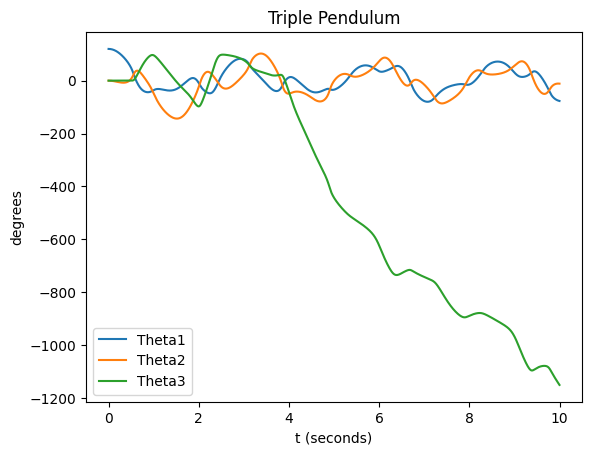

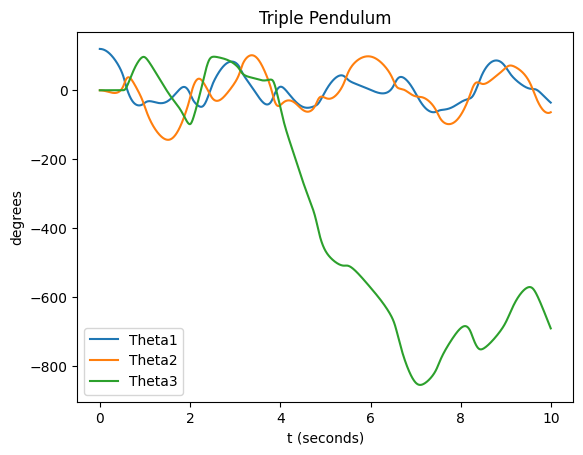

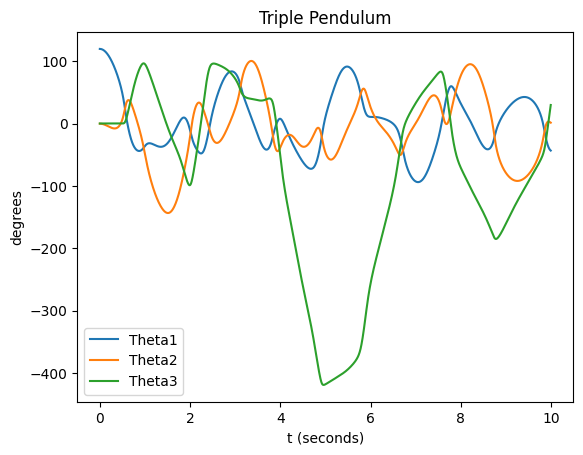

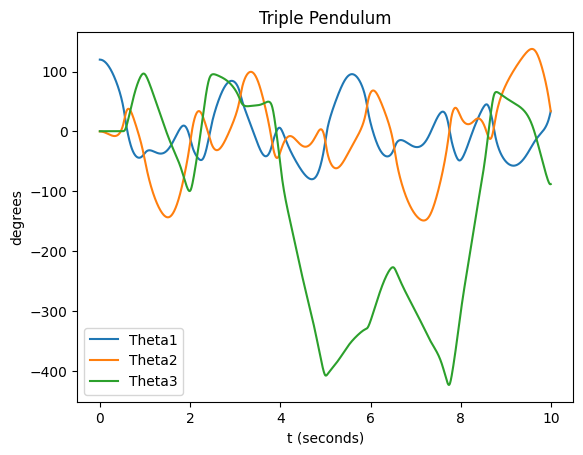

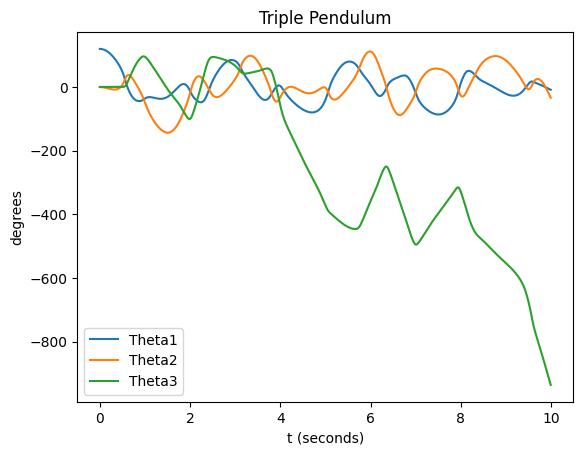

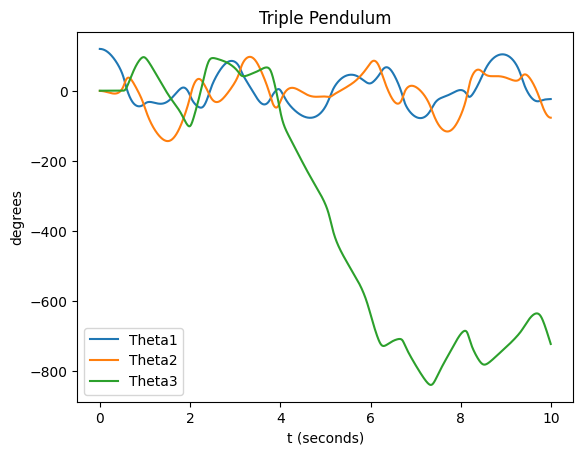

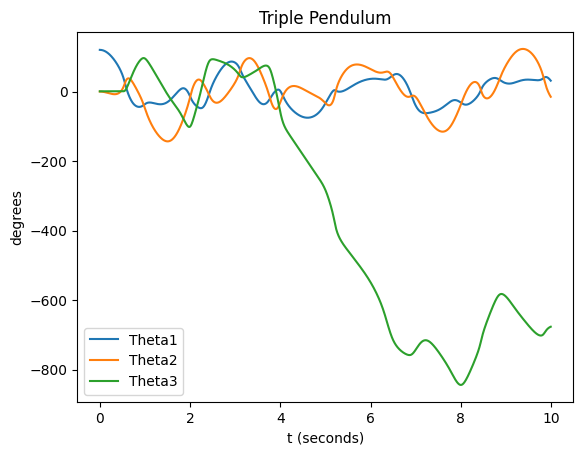

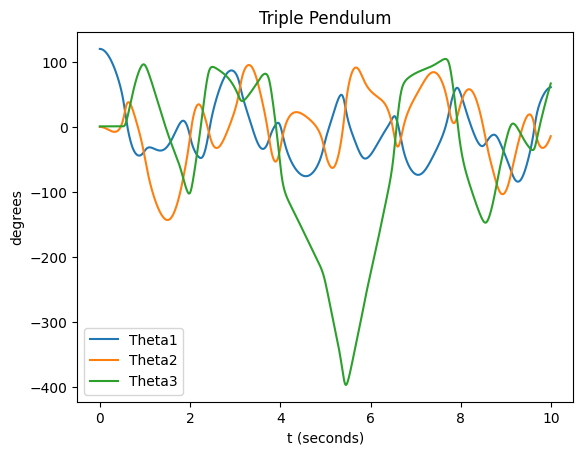

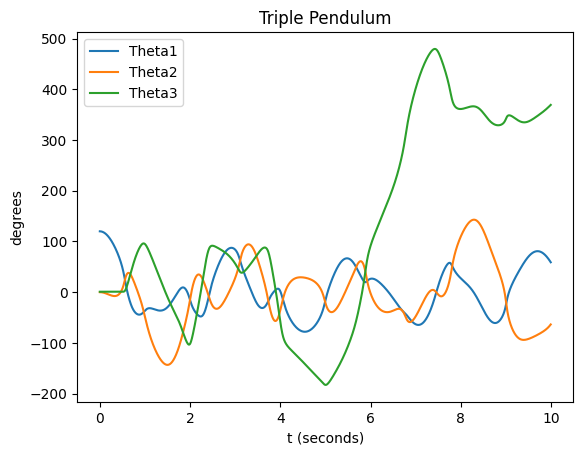

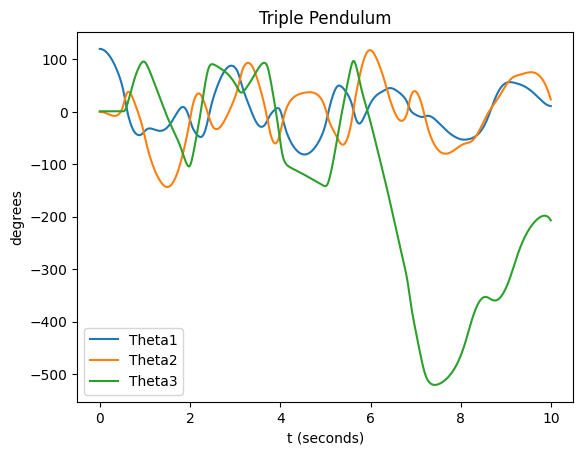

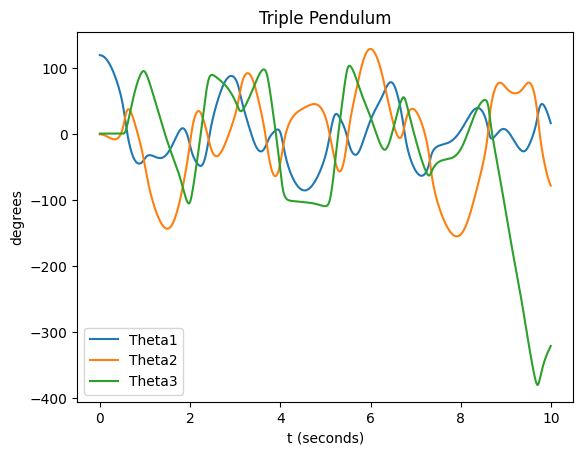

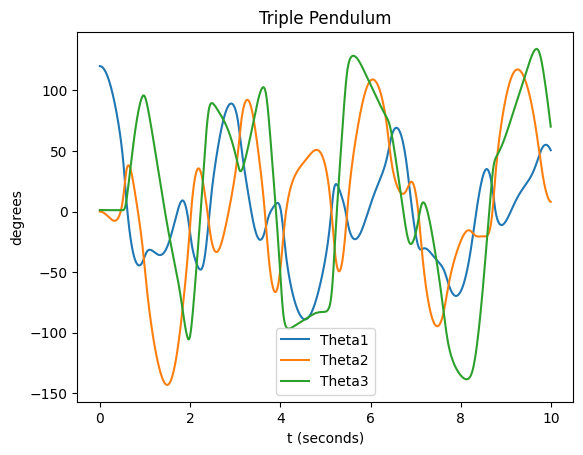

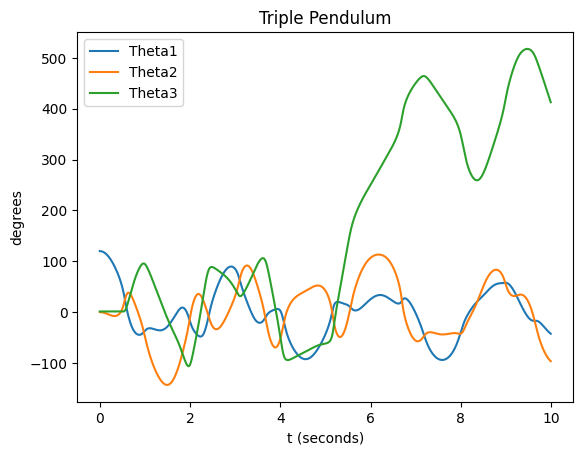

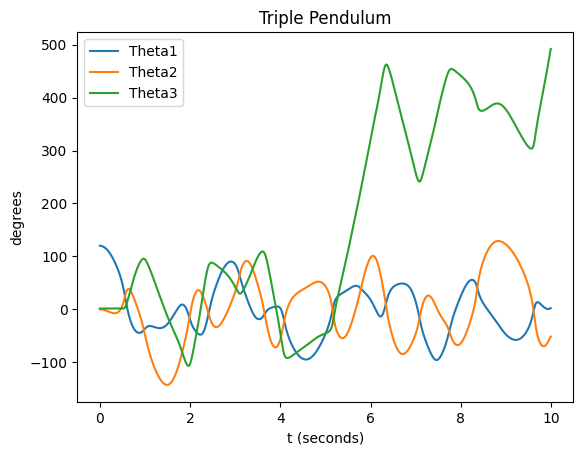

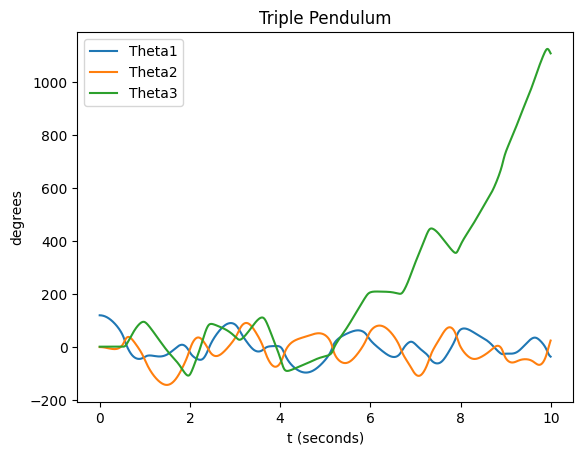

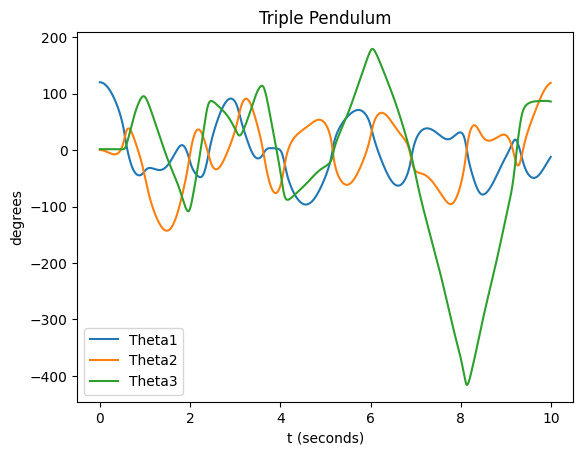

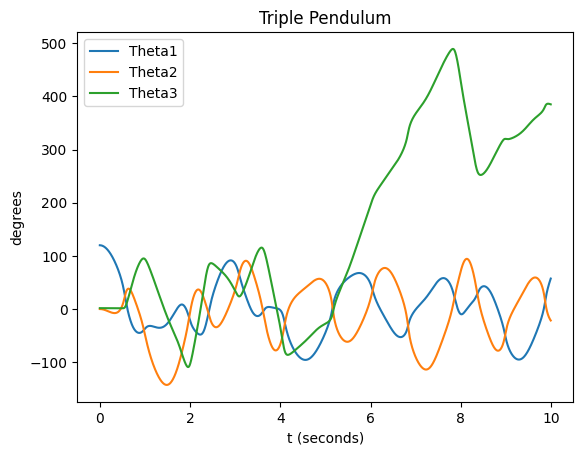

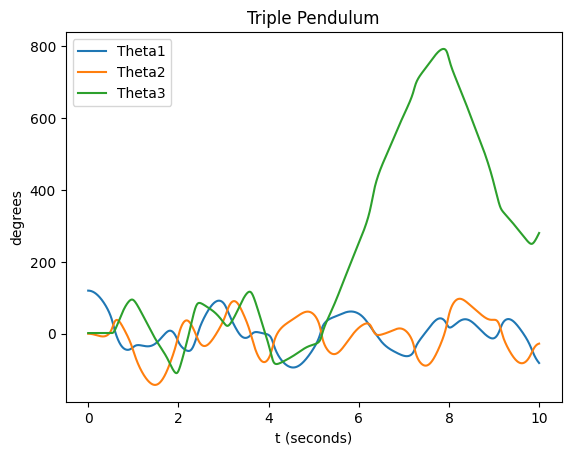

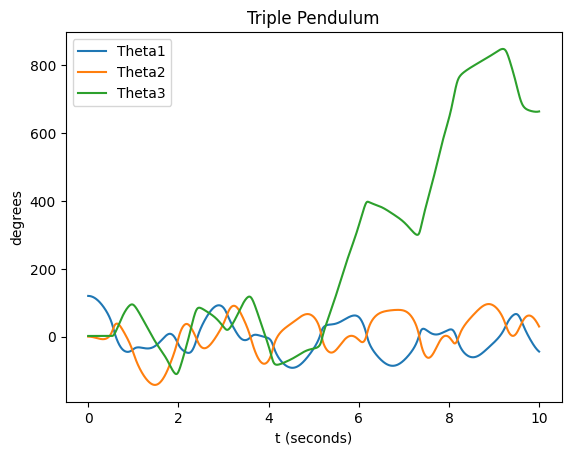

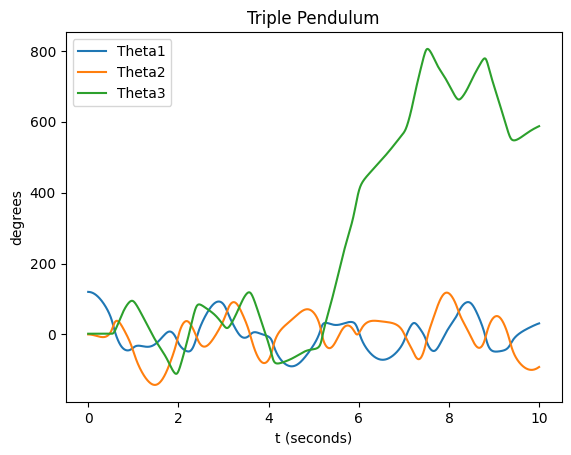

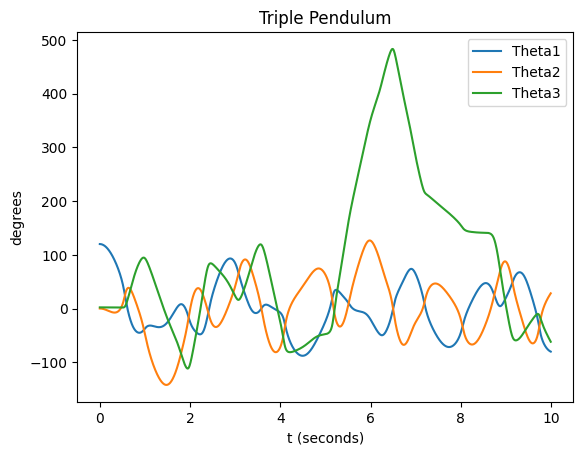

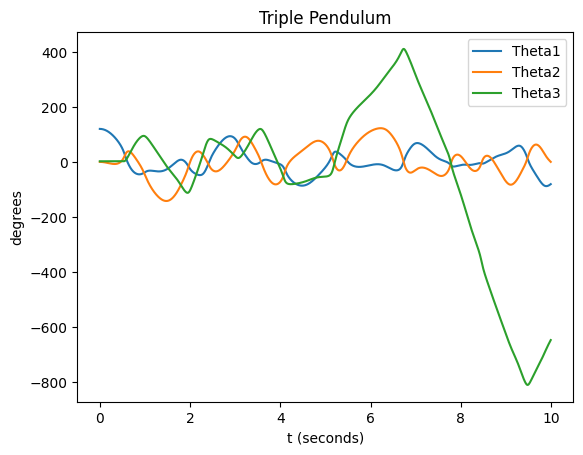

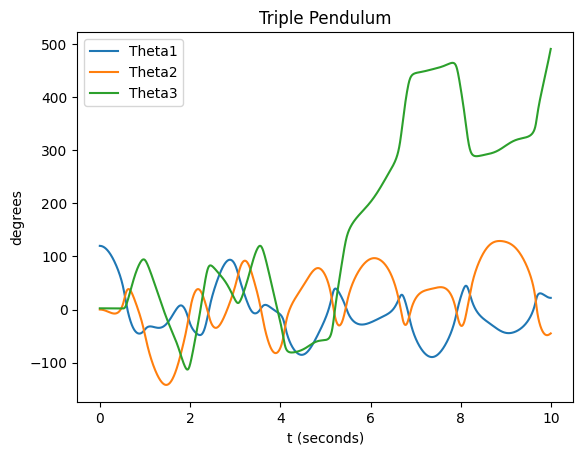

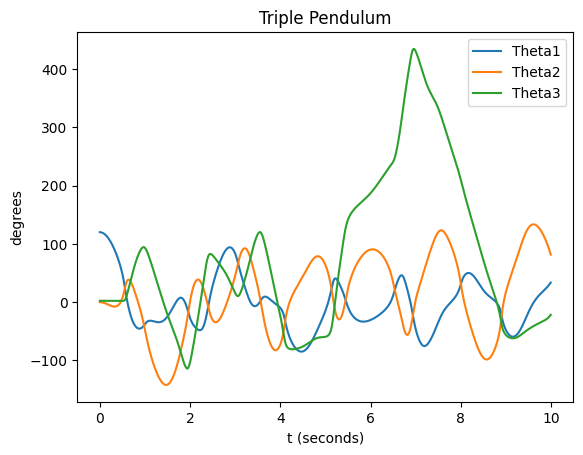

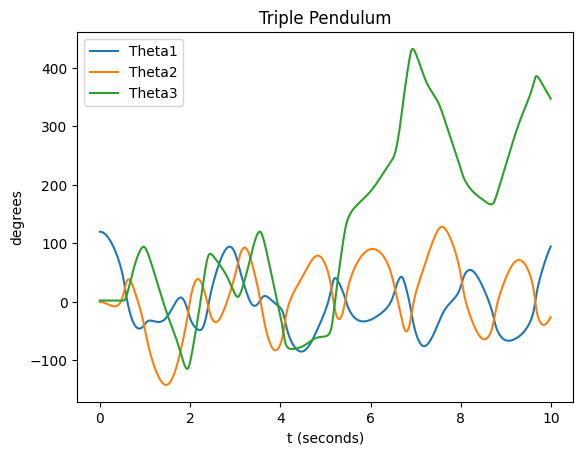

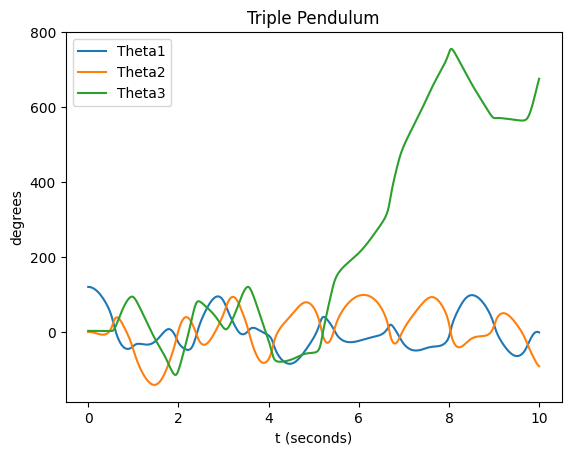

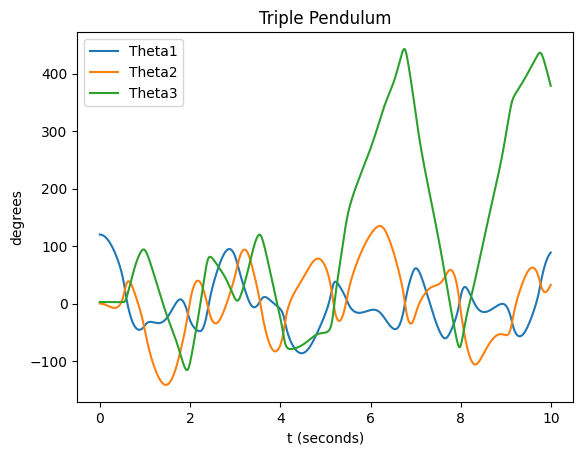

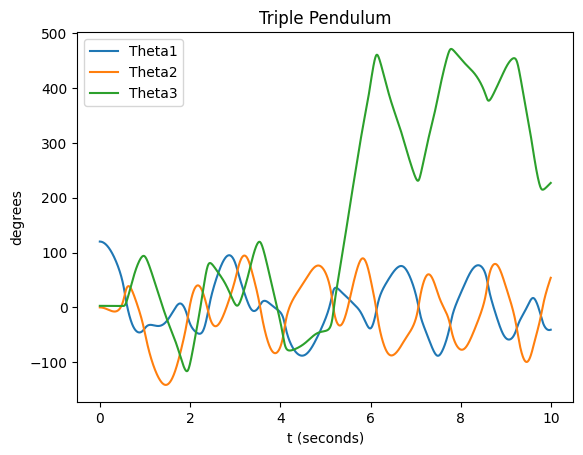

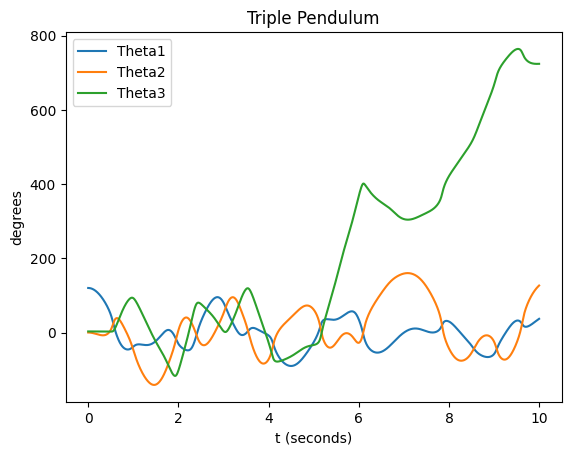

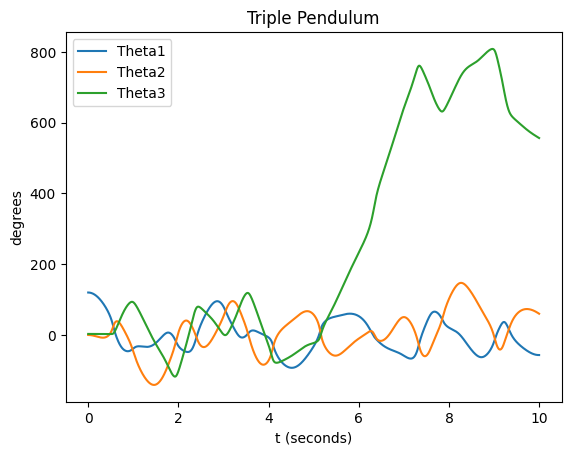

{'120_0_0.1': array([[1.        , 0.58301218, 0.92124946],
       [0.99996346, 0.58299735, 0.92124946],
       [0.99985383, 0.58295286, 0.92124945],
       ...,
       [0.01747702, 0.53795188, 0.00203728],
       [0.01638629, 0.53761   , 0.00101675],
       [0.01538932, 0.53719101, 0.        ]]), '120_0_0.2': array([[1.        , 0.5850854 , 0.89773192],
       [0.99996021, 0.58507052, 0.89773191],
       [0.99984083, 0.5850259 , 0.8977319 ],
       ...,
       [0.15845185, 0.32334646, 0.17587625],
       [0.15539949, 0.32472594, 0.17407315],
       [0.15235996, 0.32626166, 0.17225769]]), '120_0_0.3': array([[1.        , 0.58749099, 0.81298645],
       [0.99996585, 0.58747605, 0.81298643],
       [0.99986341, 0.58743126, 0.81298639],
       ...,
       [0.23994844, 0.59616802, 0.86037866],
       [0.23834678, 0.59515303, 0.86547792],
       [0.23698246, 0.59413557, 0.87052839]]), '120_0_0.4': array([[1.        , 0.51898437, 0.81480931],
       [0.99996346, 0.51897165, 0.81480929],
     

In [1]:
from __future__ import division, print_function
from math import sin, pi
import numpy as np
from pylab import plot, xlabel, ylabel, show
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi, radians
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
g = 9.81
l1 = 1
l2 = 1
l3= 1
m1 = 1.0
m2 = 1.0
m3 = 1.0

def f(q, t):
    '''Triple Pendulum equation of motion'''

    # Define relevant parameters

    # Define useful mass combinations
    m12 = m2 + m3
    m012 = m1 + m2 + m3
    mf = m012/4

    # Define useful sines
    sin0 = np.sin(q[0])
    sin1 = np.sin(q[2])
    sin2 = np.sin(q[4])

    # Define useful sine and cosine of differences
    cos01 = np.cos(q[0]-q[2])
    cos02 = np.cos(q[0]-q[4])
    cos12 = np.cos(q[2]-q[4])
    sin01 = np.sin(q[0]-q[2])
    sin02 = np.sin(q[0]-q[4])
    sin12 = np.sin(q[2]-q[4])

    # Define useful recurrent patterns
    r1 = m12*cos01*cos02 - m012*cos12
    r2 = m012 - m12*(cos01)**2
    r3 = -m012 + m3*(cos02)**2

    # Define parts of the first equation
    od1_1 = 4*m3*m12
    od1_2 = r1*cos01 + r2*cos02
    od1_3 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od1_4 = -g*m2*sin1 - g*m3*sin1 + l1*m2*sin01*q[1]**2 + l1*m3*sin01*q[1]**2 - l3*m3*sin12*q[5]**2
    od1_5 = -m3*m12*( -cos02 + np.cos(q[0]-2*q[2]+q[4]) )**2 * m012
    od1_6 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od1_7 = m3*r1**2 + m12*r3*r2

    # Define parts of the second equation
    od2_1 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od2_2 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od2_3 = -g*m2*sin1 - g*m3*sin1 + l1*m2*sin01*q[1]**2 + l1*m3*sin01*q[1]**2 - l3*m3*sin12*q[5]**2

    # Define parts of the thirds equation
    od3_1 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od3_2 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od3_3 = g*m2*sin1 + g*m3*sin1 - l1*m2*sin01*q[1]**2 - l1*m3*sin01*q[1]**2 + l3*m3*sin12*q[5]**2

    # ThetaDot equations
    td1 = q[1]
    td2 = q[3]
    td3 = q[5]

    # OmegaDot equations
    od1 = mf * ( od1_1 * od1_2 * od1_3 * r2 - 4 * ( -m3 * od1_2 * r1 + ( m3 * r1**2 + m12 * r3 * r2 ) * cos01 ) * od1_4 - ( od1_5 + 4*m3*r1**2 + 4*m12*r3*r2 ) * od1_6 ) / ( l1 * od1_7 * m012 * r2)
    od2 = ( -m3 * r1 * m012 * od2_1 * r2 - ( m3 * ( r1*cos01 + r2*cos02 ) * r1 - ( m3*r1**2 + m12*r3*r2 ) * cos01 ) * od2_2 + m012*r3*r2*od2_3 ) / ( l2 * od1_7 * r2 )
    od3 = -( m12 * (od1_2) * (od3_1) + m12 * m012 * (od3_2) * r2 - r1*m012 * od3_3 ) / ( l3 * ( m3*r1**2 + m12*r3*r2 ) )

    return np.array([td1, od1, td2, od2, td3, od3])

a = 0.0
b = 10.0
N = 2000
h = (b - a) / N

tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)  # Preallocate arrays with zeros
theta2_points = np.zeros_like(tpoints)
theta3_points = np.zeros_like(tpoints)

angles = [[120,0,0.1],[120,0,0.2],[120,0,0.3],[120,0,0.4],[120,0,0.5],[120,0,0.6],[120,0,0.7],[120,0,0.8],[120,0,0.9],[120,0,1.0],[120,0,1.1],[120,0,1.2],[120,0,1.3],[120,0,1.4],[120,0,1.5],[120,0,1.6],[120,0,1.7],[120,0,1.8],[120,0,1.9],[120,0,2.0],[120,0,2.1],[120,0,2.2],[120,0,2.3],[120,0,2.4],[120,0,2.5],[120,0,2.6],[120,0,2.7],[120,0,2.8],[120,0,2.9],[120,0,3.0]]

for x in angles:
    tpoints = np.arange(a, b, h)
    theta1_points = np.zeros_like(tpoints)
    theta2_points = np.zeros_like(tpoints)
    theta3_points = np.zeros_like(tpoints)
    q = np.array([x[0] * pi / 180, 0, x[1] * pi / 180, 0, x[2] * pi / 180, 0], float)

    for i, t in enumerate(tpoints):
        theta1_points[i] = q[0] * 180 / pi
        theta2_points[i] = q[2] * 180 / pi
        theta3_points[i] = q[4] * 180 / pi

        k1 = h * f(q, t)
        k2 = h * f(q + 0.5 * k1, t + 0.5 * h)
        k3 = h * f(q + 0.5 * k2, t + 0.5 * h)
        k4 = h * f(q + k3, t + h)
        q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

    plt.plot(tpoints, theta1_points, label='Theta1')
    plt.plot(tpoints, theta2_points, label='Theta2')
    plt.plot(tpoints, theta3_points, label='Theta3')
    plt.title("Triple Pendulum")
    plt.xlabel("t (seconds)")
    plt.ylabel("degrees")
    plt.legend()
    plt.show()

    data = np.stack((theta1_points, theta2_points, theta3_points), axis=1)
    np.save(f'pendulum_data_{str(x[0])}_{str(x[1])}_{str(x[2])}.npy', data)


# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the dataset class
class QuadraticDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)  # Shape (N, 2)
        self.y = torch.tensor(y, dtype=torch.float32)  # Shape (N, 2)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

data = {}

for i in angles:
  loaded_data = np.load(f'pendulum_data_{str(i[0])}_{str(i[1])}_{str(i[2])}.npy')
  scaler = MinMaxScaler()
  data_ = scaler.fit_transform(loaded_data)
  data[f'{str(i[0])}_{str(i[1])}_{str(i[2])}'] = data_

print(data)

def create_io_triple(data):
    x, x_1, x_2, x_3, y_1, y_2, y_3 = [], [], [], [], [], [], []

    for starting in data:
        starting_theta_1_degrees = float(starting.split("_")[0])
        starting_theta_2_degrees = float(starting.split("_")[1])
        starting_theta_3_degrees = float(starting.split("_")[2])

        starting_theta_1 = starting_theta_1_degrees * pi /180
        starting_theta_2 = starting_theta_2_degrees * pi /180
        starting_theta_3 = starting_theta_3_degrees * pi /180

        angle_data = data[starting]
        for i in range(len(angle_data)):
            x.append(tpoints[i])
            x_1.append(starting_theta_1)
            x_2.append(starting_theta_2)
            x_3.append(starting_theta_3)
            y_1.append(angle_data[i][0])
            y_2.append(angle_data[i][1])
            y_3.append(angle_data[i][2])
    return x, x_1, x_2, x_3, y_1, y_2, y_3

x, x_1, x_2, x_3, y_1, y_2, y_3 = create_io_triple(data)

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_combined = np.vstack([x_1, x_2, x_3, x]).T
scaler_x = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x_combined)

y_combined = np.vstack([y_1, y_2, y_3]).T
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_combined)

# Create dataset and dataloaders
dataset = QuadraticDataset(x_scaled, y_scaled)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

Epoch 1, Train Loss: 0.06407529687974602, Test Loss: 0.057081684094543256, R^2 Score: 0.14780409634113312
Epoch 2, Train Loss: 0.05435773302645733, Test Loss: 0.05196624141031255, R^2 Score: 0.20387935638427734
Epoch 3, Train Loss: 0.05086431073315907, Test Loss: 0.0484608866336445, R^2 Score: 0.2552202641963959
Epoch 4, Train Loss: 0.04662456368600639, Test Loss: 0.04045399317052215, R^2 Score: 0.4053299129009247
Epoch 5, Train Loss: 0.03947913195025952, Test Loss: 0.038155350182205436, R^2 Score: 0.4366702139377594
Epoch 6, Train Loss: 0.03819782231391097, Test Loss: 0.03673494378880908, R^2 Score: 0.4609115421772003
Epoch 7, Train Loss: 0.03660969731591952, Test Loss: 0.035196860348029685, R^2 Score: 0.48860296607017517
Epoch 8, Train Loss: 0.03401751164482751, Test Loss: 0.03259039389357592, R^2 Score: 0.5346626043319702
Epoch 9, Train Loss: 0.03197727512674949, Test Loss: 0.031157818441667283, R^2 Score: 0.5563086271286011
Epoch 10, Train Loss: 0.030735091038028864, Test Loss: 0.0

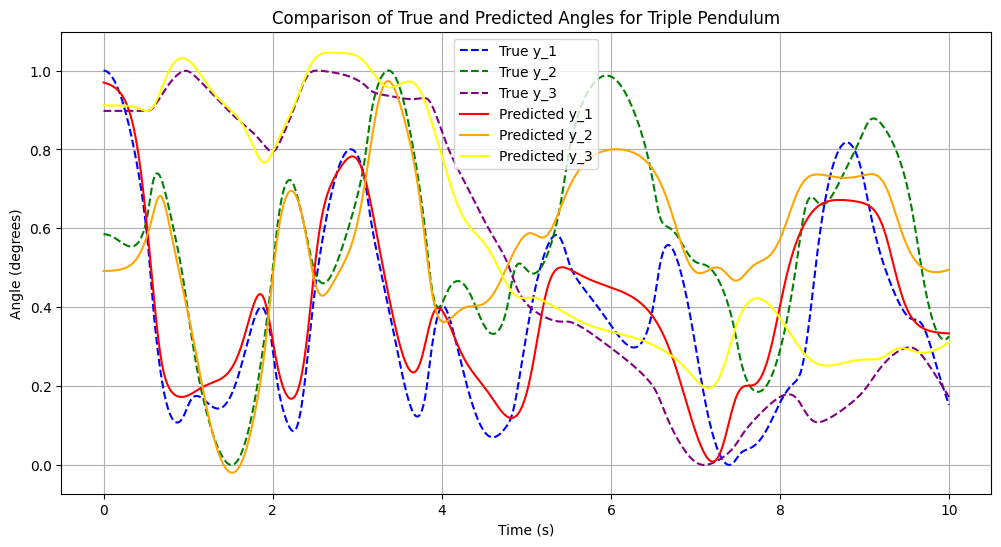

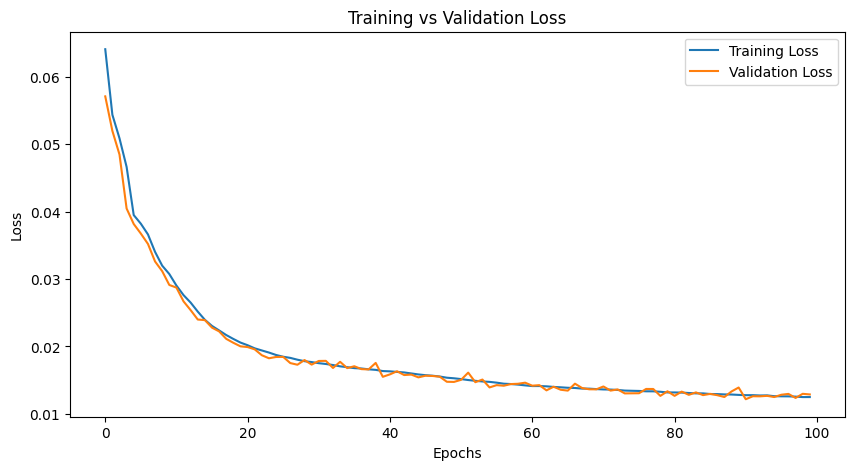

In [2]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
class StackedRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(StackedRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Output from the final time step
        return out

# Hyperparameters
input_size = 4  # Time + 3 angles
hidden_size = 64
output_size = 3  # Predict 3 angles
num_layers = 3
StackedRNN_model = StackedRNNModel(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
loss_function = nn.MSELoss().to(device)
optimizer = optim.Adam(StackedRNN_model.parameters(), lr=0.001)

early_stopping_patience = 10
best_loss = float('inf')
patience_counter = 0

# Training function with early stopping
def train_model(model, train_loader, test_loader, num_epochs):
    best_loss = float('inf')
    patience_counter = 0
    best_model = None
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            sequences = sequences.unsqueeze(1)  # Add sequence dimension
            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = loss_function(y_pred, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for sequences, targets in test_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                sequences = sequences.unsqueeze(1)  # Add sequence dimension
                y_pred = model(sequences)
                loss = loss_function(y_pred, targets)
                test_loss += loss.item()
                all_preds.append(y_pred.cpu())
                all_targets.append(targets.cpu())

        test_loss /= len(test_loader)
        val_losses.append(test_loss)

        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()

        r2 = r2_score(all_targets, all_preds, multioutput='uniform_average')
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}, R^2 Score: {r2}')

        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping")
            break

    if best_model:
        model.load_state_dict(best_model)
        torch.save(StackedRNN_model.state_dict(), 'StackedRNN_model.pth')

    return train_losses, val_losses

# Training the model
NUM_EPOCHS = 100
train_losses, val_losses = train_model(StackedRNN_model, train_loader, test_loader, NUM_EPOCHS)

# Generate predictions for 120,2
x_dense_combined = np.vstack([x_1[2000:4000], x_2[2000:4000], x_3[2000:4000], x[2000:4000]]).T
x_dense_scaled = scaler_x.transform(x_dense_combined)
x_dense_tensor = torch.tensor(x_dense_scaled, dtype=torch.float32).unsqueeze(1).to(device)

StackedRNN_model.eval()
with torch.no_grad():
    y_pred_scaled = StackedRNN_model(x_dense_tensor).cpu().numpy()

# Inverse transform predictions
y_pred_90_90 = scaler_y.inverse_transform(y_pred_scaled)

# RMSE and R^2 scores
rmse = np.sqrt(mean_squared_error(y_combined[2000:4000], y_pred_90_90))
r2 = r2_score(y_combined[2000:4000], y_pred_90_90)
print(f"Final RMSE: {rmse}")
print(f"Final R^2 Score: {r2}")

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(x[2000:4000], y_1[2000:4000], label='True y_1', color='blue', linestyle='--')
plt.plot(x[2000:4000], y_2[2000:4000], label='True y_2', color='green', linestyle='--')
plt.plot(x[2000:4000], y_3[2000:4000], label='True y_3', color='purple', linestyle='--')
plt.plot(x[2000:4000], y_pred_90_90[:, 0], label='Predicted y_1', color='red')
plt.plot(x[2000:4000], y_pred_90_90[:, 1], label='Predicted y_2', color='orange')
plt.plot(x[2000:4000], y_pred_90_90[:, 2], label='Predicted y_3', color='yellow')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Comparison of True and Predicted Angles for Triple Pendulum')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()